In [156]:
import os 
os.chdir(os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else os.getcwd())
print(os.getcwd())
!pip install -r requirements.txt

/Users/andrewkillion/Desktop/Statistical Rethinking/chapters
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [120]:
%matplotlib inline
import pymc as pm
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import warnings 

warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])

#### Code 2.1

In [4]:
ways = np.array([0, 3, 8, 9, 0])
ways / ways.sum()

array([0.  , 0.15, 0.4 , 0.45, 0.  ])

#### Code 2.2

In [6]:
stats.binom.pmf(6, n=9, p=0.5)

np.float64(0.16406250000000003)

#### Code 2.3 

In [8]:
#define grid
p_grid = np.linspace(0,1,20)

#define prior
prior = np.repeat(1, 20)

#compute likelihood at each point in the grid
likelihood = stats.binom.pmf(6, 9, p_grid)

#compute product of likelihood and prior
unstd_posterior = likelihood * prior
posterior = unstd_posterior / unstd_posterior.sum()



#### Code 2.4

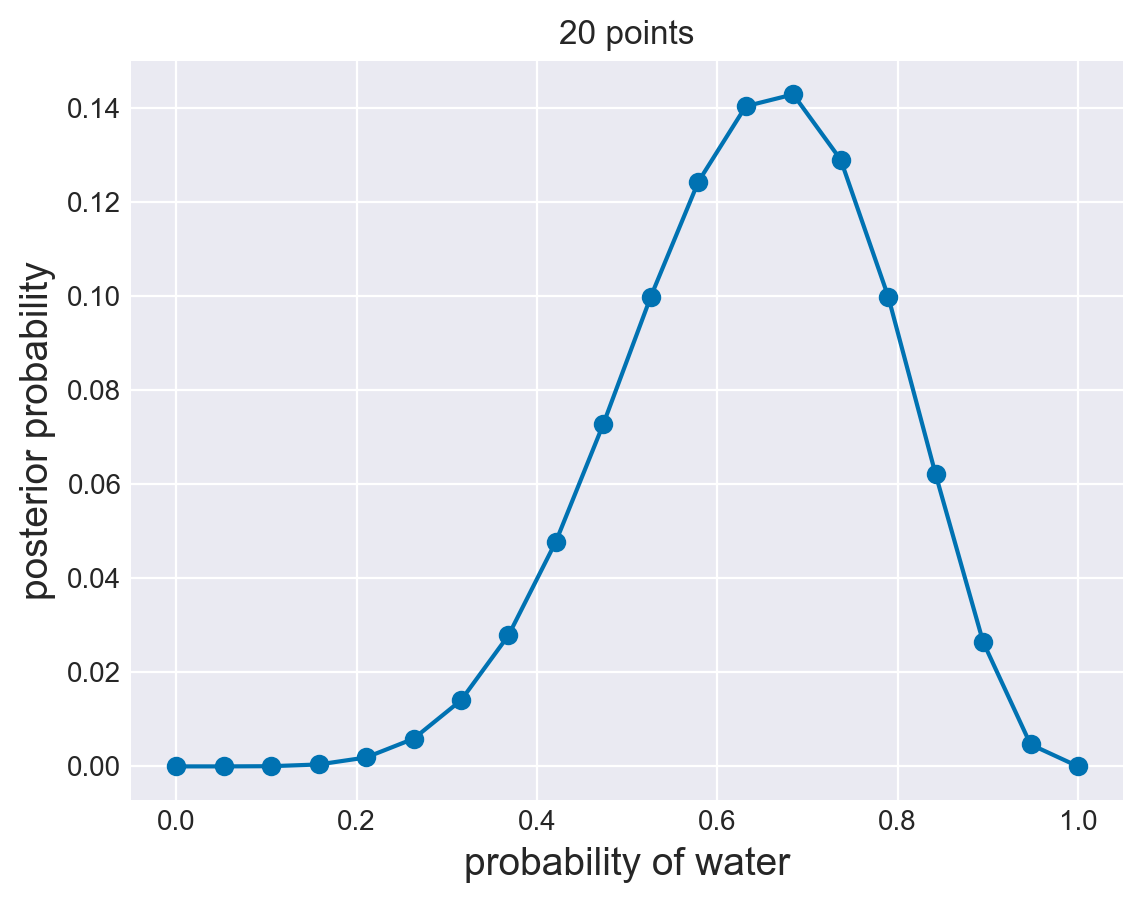

In [14]:
plt.plot(p_grid, posterior, 'o-')
plt.xlabel('probability of water', fontsize=14)
plt.ylabel('posterior probability', fontsize=14)
plt.title('20 points');

#### Code 2.5

In [ ]:
prior = np.where(p_grid < 0.5, 0, 1)
prior = np.exp(-5*abs(p_grid - 0.5))

#### Code 2.6

Editor's note: quap functions very similarly to PYMC (both syntactically and under the hood).  So we're going to jump straight to PYMC instead of building an entire class of functions that are in the rethinking package.  Maybe someday I'll get to that but it would be objectively impractical.  We'll have to brute force some of the outputs for now but it mimics quap quite well

In [ ]:
w, n = 6, 9
def quap(w: int, n: int):
    data = np.repeat((0, 1), (n-w, w))

    with pm.Model() as normal_approximation:
        p = pm.Uniform('p', 0, 1)
        w_obs = pm.Binomial('w', n=len(data), p=p, observed=data.sum())
        mean_q = pm.find_MAP(progressbar=False)

    p_map = mean_q['p']
    hessian = -(w / (p_map**2) + (n-w) / ((1-p_map)**2))
    var_q = -1.0 / hessian
    std_q = var_q ** 0.5

    hdi_l = np.clip(stats.norm.ppf(0.055, mean_q['p'], std_q), 0, 1)
    hdi_h = np.clip(stats.norm.ppf(0.945, mean_q['p'], std_q), 0, 1)

    precis = pd.DataFrame({'Mean': round(float(mean_q['p']), 2), 
                'StdDev': round(float(std_q), 2), 
                '5.5%': round(float(hdi_l), 2), 
                '94.5%': round(float(hdi_h), 2)}, index=['p'])

    return p_map, std_q, precis

mean, std, precis = quap(6, 9)

precis

,Mean,StdDev,5.5%,94.5%
p,0.67,0.16,0.42,0.92


#### Code 2.7

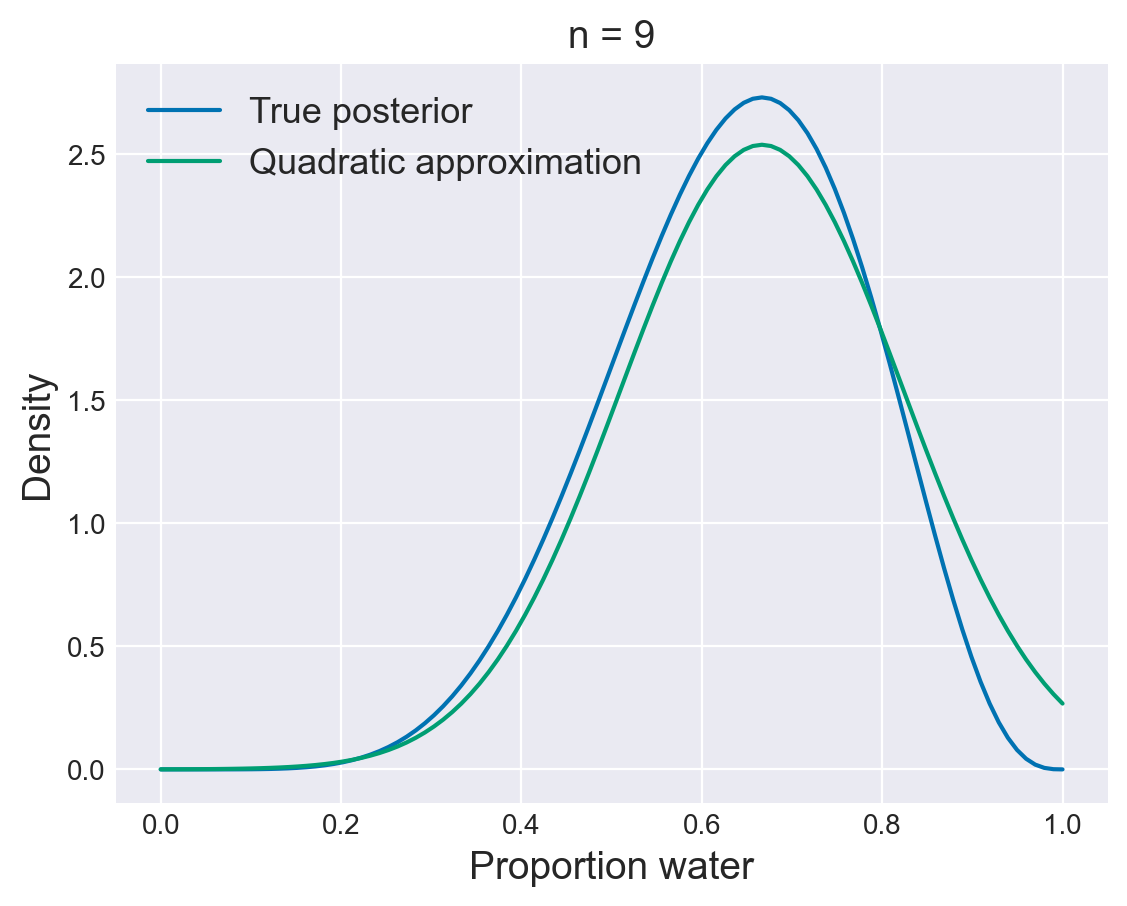

In [151]:
# analytical calculation
n = 9 #change this to adjust the sample size
water_proportion = 2/3 #change this to adjust the true proportion of water
w = n * water_proportion

x = np.linspace(0, 1, 100)

mean, std, _ = quap(w, n)
plt.plot(x, stats.beta.pdf(x , w+1, n-w+1),
         label='True posterior')

# quadratic approximation
plt.plot(x, stats.norm.pdf(x, mean, std),
         label='Quadratic approximation')
plt.legend(loc=0, fontsize=13)

plt.title('n = {}'.format(n), fontsize=14)
plt.xlabel('Proportion water', fontsize=14)
plt.ylabel('Density', fontsize=14);

#### Code 2.8

In [136]:
n_samples = 1000 
p = np.repeat(None, n_samples)
p[1] = 0.5 
w = 6 
l = 3

for i in range(2, n_samples): 
    p_new = np.random.normal(1, p[i-1])
    if p_new < 0: 
        p_new = abs(p_new)
    elif p_new > 1: 
        p_new = 2 - p_new
    q0 = stats.binom.pmf(w, w+l, p[i-1])
    q1 = stats.binom.pmf(w, w+l, p_new)
    p[i] = np.where(np.random.rand() < q1/q0, p_new, p[i-1])

#### Code 2.9

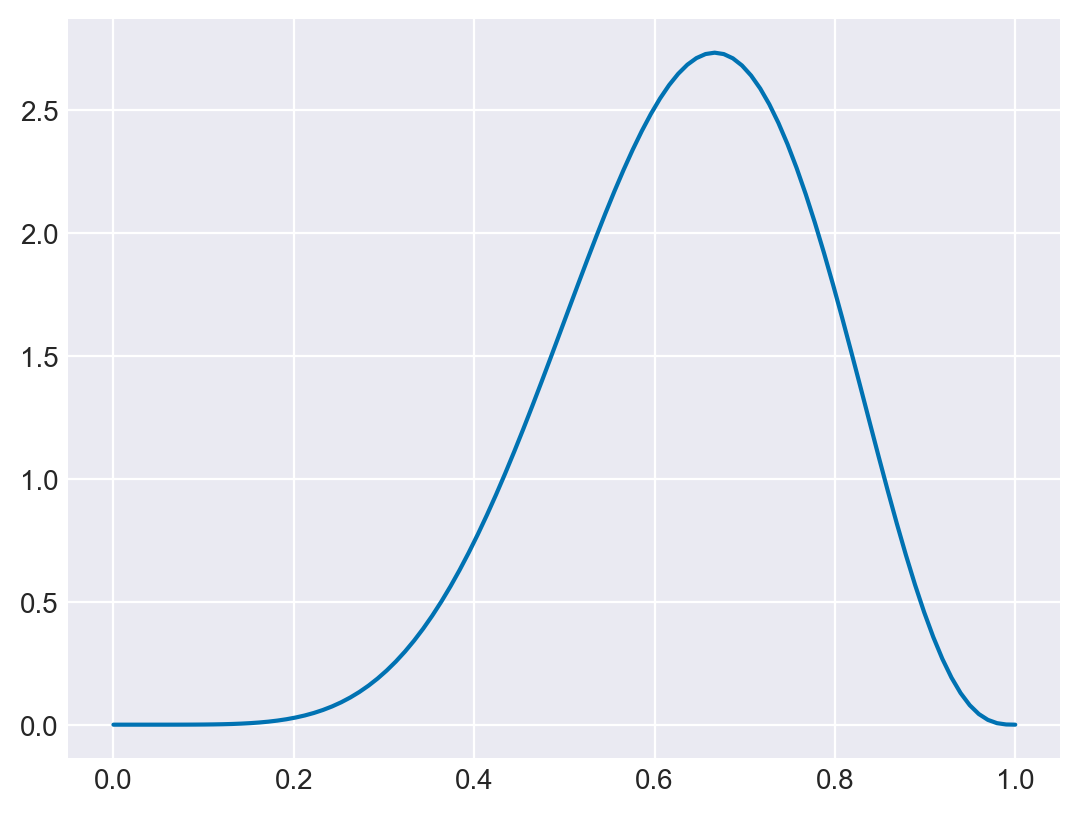

In [ ]:
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x, w+1, l+1),
         label='True posterior');